In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("bmh")

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve

from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from timeit import default_timer as timer

In [5]:
import os
os.chdir("D:\ml\kursov")

## 1. Набор данных для анализа. Описание.

Сборник SMS-спама - это общедоступный набор данных SMS-сообщений с метками, которые были собраны для исследования спама на мобильных телефонах. В наборе данных есть одна коллекция, состоящая из 5 574 английских реальных и некодированных сообщений, помеченных как законные или спам.

Файл содержит по одному сообщению на строку. Каждая строка состоит из двух столбцов: один с меткой (ветчина или спам), а другой с необработанным текстом. http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

#### Загрузка DataFrame

In [6]:
sms = pd.read_csv('SMSSpamCollection.txt', sep='	')
sms.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


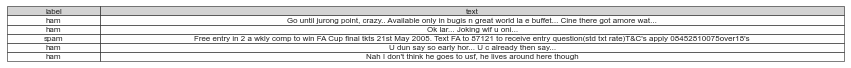

In [7]:
fig,ax = plt.subplots(figsize=(15,1))
#ax.autoscale(enable=True, axis='both', tight=True)
ax.axis('off')
the_table=ax.table(cellText=sms[:5].values,colLabels=sms[:5].columns, cellLoc='center',
                          loc='bottom',bbox=[0,0,1,1],colColours=['lightgrey', 'lightgrey'], colWidths = [0.5,4])
the_table.auto_set_font_size('best')
the_table.scale(2,2.25)

pp=PdfPages('Таблица1.Первые строки данных.pdf')
pp.savefig(fig,bbox_inches='tight')
pp.close()

## 2. Предварительный анализ и очистка данных.

#### Количество данных в наборе

In [8]:
sms.shape

(5572, 2)

#### Количество отсутствующих данных в каждом столбце

In [9]:
sms.isna().sum() 

label    0
text     0
dtype: int64

#### Типы столбцов

In [10]:
sms.dtypes

label    object
text     object
dtype: object

In [11]:
sms.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Можно отметить, что label имеет два уникальных значения: spam и ham. В работе с данным датасетом label является целевой переменной. 

In [12]:
sms.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

Label содержит 747 спам-сообщений и 4825 сообщения, не содержащих спама.

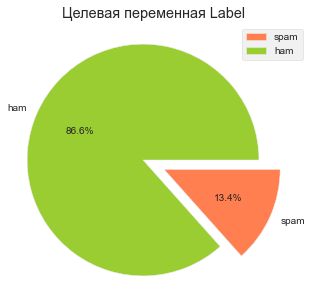

In [13]:
labels = ['spam', 'ham']
x = [747, 4825] # количество сообщений определенного label

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(x, labels=labels, explode = (0.3, 0),autopct='%1.1f%%', colors = ['coral','yellowgreen'], 
        radius = 1.5, counterclock = False)
plt.title('Целевая переменная Label')
ax1.axis('equal')
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))
plt.show()

### Вывод точечных данных

#### Пример спама

In [14]:
sms.iloc[2]

label                                                 spam
text     Free entry in 2 a wkly comp to win FA Cup fina...
Name: 2, dtype: object

#### Пример сообщения

In [15]:
sms.iloc[4]

label                                                  ham
text     Nah I don't think he goes to usf, he lives aro...
Name: 4, dtype: object

In [16]:
sms['text_len'] = sms.text.apply(len)
sms.head()

,label,text,text_len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Характеристика длины обычных сообщений

In [17]:
sms[sms.label=='ham'].describe()

,text_len
count,4825.000000
mean,71.482487
std,58.440652
min,2.000000
25%,33.000000
50%,52.000000
75%,93.000000
max,910.000000


In [18]:
sms[sms.text_len == 910].text.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

#### Характеристика длины спам сообщений

In [19]:
sms[sms.label=='spam'].describe()

,text_len
count,747.000000
mean,138.670683
std,28.873603
min,13.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,223.000000


Text(0, 0.5, 'Количество')

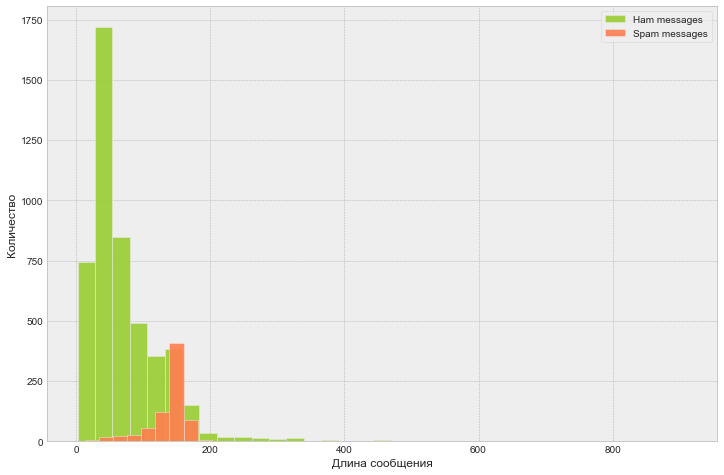

In [20]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].text_len.plot(bins=35, kind='hist', color='yellowgreen', 
                                       label='Ham messages', alpha=0.9)
sms[sms.label=='spam'].text_len.plot(kind='hist', color='coral', 
                                       label='Spam messages', alpha=0.9)
plt.legend()
plt.xlabel('Длина сообщения')

plt.ylabel('Количество')

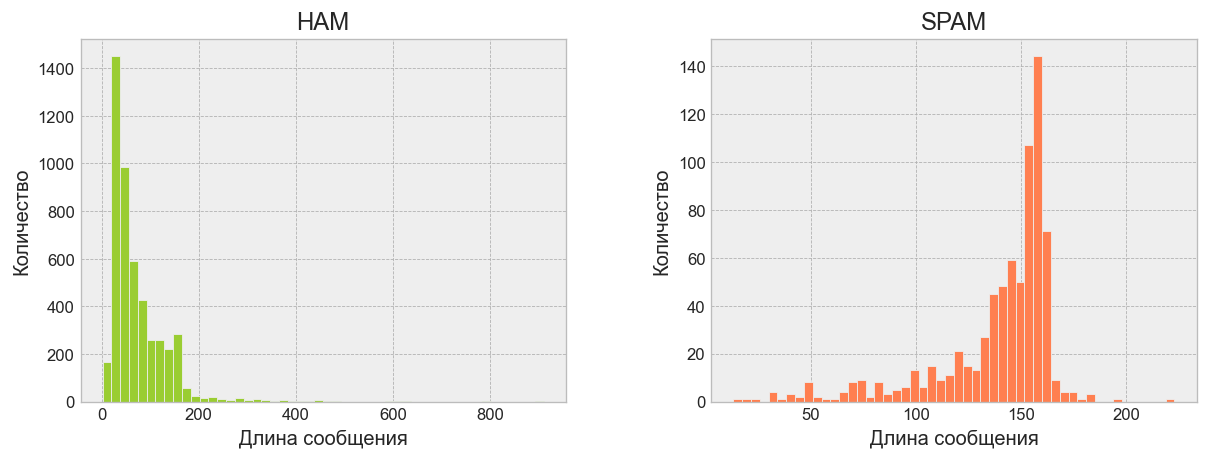

In [21]:
fig,ax = plt.subplots(1,2,figsize=(12,4),dpi = 120)

sms[sms['label']=='ham'].hist(column='text_len', bins=50,ax=ax[0],color = 'yellowgreen')
ax[0].set(xlabel = 'Длина сообщения',ylabel = 'Количество',title = 'HAM')
sms[sms['label']=='spam'].hist(column='text_len', bins=50,ax=ax[1],color = 'coral')
ax[1].set(xlabel = 'Длина сообщения',ylabel = 'Количество',title = 'SPAM');

То есть можно сделать вывод, о том что длина спама превышает длину обычных сообщений. 

## Предварительная обработка текста, устранение шума

Построение функции: (принимает строку)
1. Удаление знаков препинания
2. Удаление стоп-слов
3. Возвращение чистого текста

In [22]:
import string
from nltk.corpus import stopwords

def text_pre_pro(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    mess = mess.replace('.',' ')
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS])

In [23]:
text_pre_pro('i will ?%call you later')

'call later'

In [24]:
sms['clean_text'] = sms.text.apply(text_pre_pro)
sms.head()

,label,text,text_len,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though


In [25]:
sms = sms.drop(['text'], axis = 1)
sms.head()

,label,text_len,clean_text
0,ham,111,go jurong point crazy available bugis n great ...
1,ham,29,ok lar joking wif oni
2,spam,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,49,dun say early hor c already say
4,ham,61,nah think goes usf lives around though


## 3. Преобразование атрибутов исходного датасета в числовые признаки. Векторизация текста.

Замена значений Label на числовые значения: 'ham':1, 'spam':0. Вследствие чего, удаляем столбец label. Теперь label_num стала бинарной целевой переменной

In [26]:
sms['label_num'] = sms.label.map({'ham':1, 'spam':0})
sms.head()

,label,text_len,clean_text,label_num
0,ham,111,go jurong point crazy available bugis n great ...,1
1,ham,29,ok lar joking wif oni,1
2,spam,155,free entry wkly comp win fa cup final tkts 21s...,0
3,ham,49,dun say early hor c already say,1
4,ham,61,nah think goes usf lives around though,1


In [27]:
sms = sms.drop(['label'], axis = 1)
sms.head()

,text_len,clean_text,label_num
0,111,go jurong point crazy available bugis n great ...,1
1,29,ok lar joking wif oni,1
2,155,free entry wkly comp win fa cup final tkts 21s...,0
3,49,dun say early hor c already say,1
4,61,nah think goes usf lives around though,1


In [28]:
sms.dtypes

text_len       int64
clean_text    object
label_num      int64
dtype: object

### Разделение данных

In [29]:
X = sms['clean_text']
y = sms['label_num']

In [30]:
X_train1, X_test1, y_train, y_test = train_test_split(X, y,  test_size = 0.3)
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(3900,)
(1672,)
(3900,)
(1672,)


### Векторизация текстов

In [31]:
cv = CountVectorizer()
cv.fit(X_train1)

len(cv.vocabulary_)

7443

In [32]:
X_train = cv.transform(X_train1)
X_train

<3900x7443 sparse matrix of type '<class 'numpy.int64'>'
	with 32717 stored elements in Compressed Sparse Row format>

In [33]:
print(X_train1[X_train1.index[3]])

let snow let snow kind weather brings ppl together friendships grow


In [34]:
X_train[3].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1476, 2924, 3155, 3799, 3951, 5124, 6021, 6660, 7118]))

In [35]:
X_test = cv.transform(X_test1)

In [36]:
print ('Vocabulary:') 
print (cv.vocabulary_) 

Vocabulary:
{'hi': 3308, 'technical': 6466, 'support': 6344, 'providing': 5241, 'assistance': 1088, 'us': 6923, 'customer': 2066, 'call': 1566, 'email': 2497, 'ooh': 4756, '4got': 527, 'gonna': 3089, 'start': 6188, 'belly': 1284, 'dancing': 2093, 'moseley': 4423, 'weds': 7131, '30': 434, 'want': 7075, 'join': 3701, 'cafe': 1557, 'yup': 7429, 'next': 4572, 'stop': 6231, 'let': 3951, 'snow': 6021, 'kind': 3799, 'weather': 7118, 'brings': 1476, 'ppl': 5124, 'together': 6660, 'friendships': 2924, 'grow': 3155, 'used': 6927, 'hope': 3361, 'agents': 861, 'drop': 2386, 'since': 5913, 'ive': 3641, 'booked': 1398, 'things': 6561, 'year': 7375, 'whole': 7193, 'boston': 1411, 'nyc': 4683, 'experiment': 2638, 'ask': 1075, 'meeting': 4264, 'da': 2079, 'ge': 3012, 'tmr': 6645, 'nite': 4594, 'winner': 7224, 'specially': 6106, 'selected': 5753, 'receive': 5387, '1000': 236, 'cash': 1642, 'holiday': 3344, 'flights': 2807, 'inc': 3514, 'speak': 6100, 'live': 4007, 'operator': 4764, 'claim': 1788, '08712

## 4. Обучение моделей для решения задачи бинарной классификации.

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
import time

### Выбираем несколько моделей для решения 

In [40]:
mnb = MultinomialNB()
svc = SVC(probability=True, random_state = 42)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state = 42)
lrc = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(random_state = 42)
mlp = MLPClassifier(random_state = 42)

In [41]:
clfs = {'SVC' : svc, 'NB': mnb, 'LR': lrc, 'RF': rfc,'DT': dtc, 'KN' : knc,'MLP': mlp}

In [42]:
# def models(clfs, feature_train, labels_train, feature_test, labels_test):
#     acc = []
#     auc = []
#     tim = []
#     for k,v in clfs.items():
#         start_time = time.time()
#         v.fit(feature_train, labels_train)
#         tim.append(time.time() - start_time)
#         y_pred = v.predict(feature_test)
#         ww1 = metrics.accuracy_score(labels_test, y_pred)
#         acc.append(ww1)
#         if k == 'DT':
#             w2 = metrics.roc_auc_score(labels_test, y_pred)
#             auc.append(w2)
#         else:
#             y_pred_prob = v.predict_proba(X_test)[:, 1]
#             w2 = metrics.roc_auc_score(labels_test, y_pred_prob)
#             auc.append(w2)
#         print(v)
#         print('Accuracy',ww1)
#         print('ROC AUC',w2)
#         print(metrics.confusion_matrix(labels_test, y_pred))
#         print(metrics.classification_report(labels_test, y_pred))
#     return acc, auc, tim

In [43]:
from sklearn import metrics
def models(clfs, feature_train, labels_train, feature_test, labels_test):
    acc = []
    auc = []
    tr_tim = []
    pr_tim = []
    run_tim = []
    precis = []
    rec = []
    ff = []
    for k,v in clfs.items():
        start_time = time.time()
        v.fit(feature_train, labels_train)
        tr_tim.append(time.time() - start_time)
        start_time2 = time.time()
        y_pred = v.predict(feature_test)
        pr_tim.append(time.time() - start_time2)
        run_tim.append(time.time() - start_time)
        ww1 = accuracy_score(labels_test, y_pred)
        acc.append(ww1)
        p = average_precision_score(labels_test, y_pred)
        precis.append(p)
        r = recall_score(labels_test, y_pred, average = 'micro')
        rec.append(r)
        f = f1_score(labels_test, y_pred)
        ff.append(f)
        if k == 'DT':
            w2 = roc_auc_score(labels_test, y_pred)
            auc.append(w2)
        else:
            y_pred_prob = v.predict_proba(X_test)[:, 1]
            w2 = roc_auc_score(labels_test, y_pred_prob)
            auc.append(w2)
        print(v)
        print('Accuracy',ww1)
        print('ROC AUC',w2)
        print(metrics.confusion_matrix(labels_test, y_pred))
        print(metrics.classification_report(labels_test, y_pred))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
    return acc, auc, tr_tim, pr_tim, run_tim, precis, rec, ff

In [44]:
r1, r2, tr_tim, pr_tim, run_tim, precis,rec, ff = models(clfs, X_train, y_train, X_test, y_test)

SVC(probability=True, random_state=42)
Accuracy 0.9748803827751196
ROC AUC 0.9796617582738008
[[ 187   41]
 [   1 1443]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       228
           1       0.97      1.00      0.99      1444

    accuracy                           0.97      1672
   macro avg       0.98      0.91      0.94      1672
weighted avg       0.98      0.97      0.97      1672

MultinomialNB()
Accuracy 0.9808612440191388
ROC AUC 0.9826717937503037
[[ 209   19]
 [  13 1431]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       228
           1       0.99      0.99      0.99      1444

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672

LogisticRegression(solver='liblinear')
Accuracy 0.9760765550239234
ROC AUC 0.9870182728288865
[[ 192   36]
 [   4 1440]]
      

In [45]:
res_mod1 = pd.DataFrame(run_tim, index=['SVC', 'NB', 'LR', 'RF','DT', 'KN','MLP'], columns=['Run time'])
res_mod1['Training time'] = tr_tim
res_mod1['Test time'] = pr_tim
res_mod1['Accuracy'] = r1
res_mod1['ROC AUC'] = r2
res_mod1['Precision'] = precis
res_mod1['Recall'] = rec
res_mod1['F1'] = ff
res_mod1

,Run time,Training time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
SVC,5.582140,5.254102,0.328038,0.974880,0.979662,0.972297,0.974880,0.985656
NB,0.000000,0.000000,0.000000,0.980861,0.982672,0.985787,0.980861,0.988943
LR,0.374497,0.374497,0.000000,0.976077,0.987018,0.975300,0.976077,0.986301
RF,1.859522,1.718944,0.140578,0.968900,0.988636,0.965241,0.968900,0.982313
DT,0.215349,0.214378,0.000971,0.964713,0.896468,0.968465,0.964713,0.979788
KN,0.439926,0.000000,0.439926,0.901914,0.804825,0.898010,0.901914,0.946265
MLP,123.681228,123.649988,0.031240,0.978469,0.977369,0.976241,0.978469,0.987680


In [46]:
res_mod = pd.DataFrame(r1,index=['SVC', 'NB', 'LR', 'RF','DT', 'KN','MLP'], columns=['Accuracy'])
res_mod['ROC AUC'] = r2
res_mod['F1'] = ff

In [47]:
# r1, r2, tim = models(clfs, X_train, y_train, X_test, y_test)

In [48]:
# res_mod = pd.DataFrame(r1,index=['SVC', 'NB', 'LR', 'RF','DT', 'KN','MLP'], columns=['Accuracy'])
# res_mod['ROC AUC'] = r2
# #таблица для гистограммы, учитывающей время
# res_mod1 = pd.DataFrame(r1,index=['SVC', 'NB', 'LR', 'RF','DT', 'KN','MLP'], columns=['Accuracy'])
# res_mod1['ROC AUC'] = r2
# res_mod1['Time'] = tim

In [49]:
# res_mod1

В результате можно сделать вывод о том, что модели SVC, RF, MLP обучаются долгое время

C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:226: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\style.py:27: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


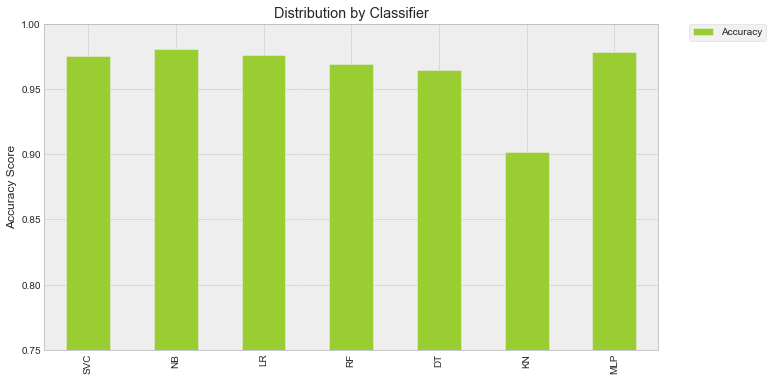

In [50]:
res_mod1['Accuracy'].plot(kind='bar', ylim=(0.75,1.0), figsize=(11,6), align='center', colormap="Accent",color=['yellowgreen'])
plt.xticks(np.arange(7), res_mod.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

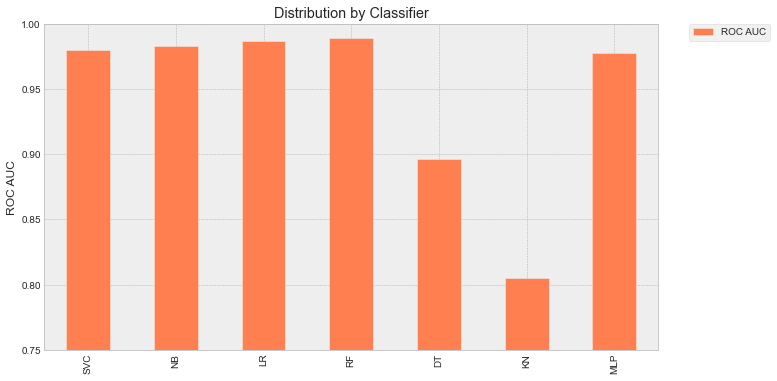

In [51]:
res_mod['ROC AUC'].plot(kind='bar', ylim=(0.75,1.0), figsize=(11,6), align='center', colormap="Accent",color=['coral'])
plt.xticks(np.arange(7), res_mod.index)
plt.ylabel('ROC AUC')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

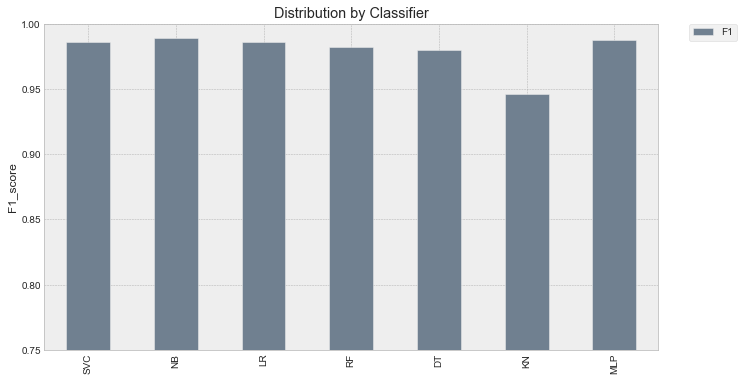

In [52]:
res_mod['F1'].plot(kind='bar', ylim=(0.75,1.0), figsize=(11,6), align='center', colormap="Accent",color=['slategray'])
plt.xticks(np.arange(7), res_mod.index)
plt.ylabel('F1_score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Рассматриваем модели с наилучшими показателями времени

In [54]:
res_mod1 = res_mod1.drop(res_mod1[res_mod1['Run time'] > 1].index)
res_mod_time = [i for i in run_tim if i<1]
res_mod1 = res_mod1.drop(['Run time'], axis = 1)
res_mod1 = res_mod1.drop(['Training time'], axis = 1)
res_mod1 = res_mod1.drop(['Test time'], axis = 1)
res_mod1 = res_mod1.drop(['Precision'], axis = 1)
res_mod1 = res_mod1.drop(['Recall'], axis = 1)

C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:226: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\style.py:27: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


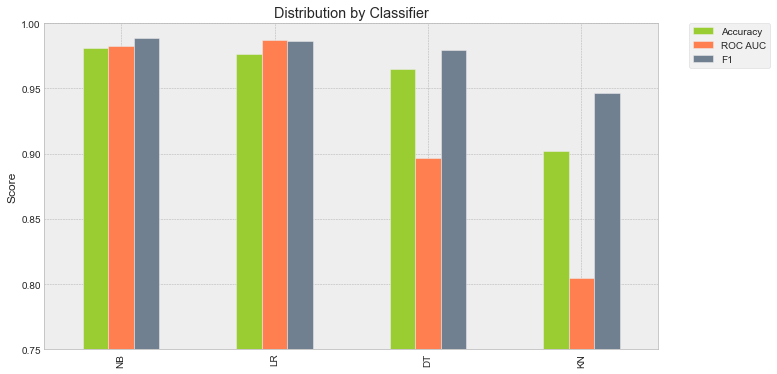

In [55]:
res_mod1.plot(kind='bar', ylim=(0.75,1.0), figsize=(11,6), align='center', colormap="Accent",color=['yellowgreen','coral','slategray'])
plt.xticks(np.arange(len(res_mod1)), res_mod1.index)
plt.ylabel('Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Анализируя, такие парамаетры моделей как Accuracy, ROC AUC и время обучения, можно сделать вывод о том, что лучшие показатели имеет модель логистической регрессии, метод Байеса, метод k-ближайших соседей и деревья решений

## 5. Лучшие модели. Изменение гиперпараметров, GridSearch

In [86]:
# функция выводит основные метрики для оценки качества модели и возвращает вектор предсказанных значений
def mod2(m,X_train, y_train,X_test,y_test):
    m.fit(X_train, y_train)
    y_pred_class = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:, 1]
    # calculate accuracy
    print('Accuracy',metrics.accuracy_score(y_test, y_pred_class))
    # calculate AUC
    print('ROC AUC',metrics.roc_auc_score(y_test, y_pred_prob))
    print('F1-score',f1_score(y_test, y_pred_class))
    print('')

    print(classification_report(y_test,y_pred_class))

    conf_matrix = metrics.confusion_matrix(y_test, y_pred_class)
    print(conf_matrix)  
    sns.heatmap(conf_matrix/np.sum(conf_matrix),annot=True, fmt='.2%', cmap='Blues')
    #metrics.plot_confusion_matrix(m,X_test,y_test)

    probs = m.predict_proba(X_test)
    probs = probs[:, 1]
    fpr , tpr , _ = roc_curve(y_test, probs)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC {m}')
    plt.legend(loc="lower right")
    plt.grid()
    return y_pred_class

In [87]:
# функция возвращает вектор, содержащий индексы значений, которые были неправильно классифицированы
def k_mistakes(vec_pred):
    data_compare = pd.DataFrame({
    "Real": y_test,
    "Predicted": vec_pred
    })

    ## Дата-фрейм предсказанных и реальных данных: 
    ## mist содержит index с неправильной классификацией
    mist = []
    for i in data_compare.index:
        if data_compare.Real[i] != data_compare.Predicted[i]:
            mist.append(i)
    return mist

## LogisticRegression
## Логистическая регрессия

Accuracy 0.9760765550239234
ROC AUC 0.9870182728288865
F1-score 0.9863013698630138

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       228
           1       0.98      1.00      0.99      1444

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672

[[ 192   36]
 [   4 1440]]


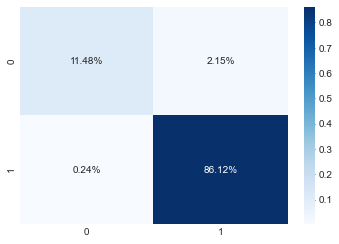

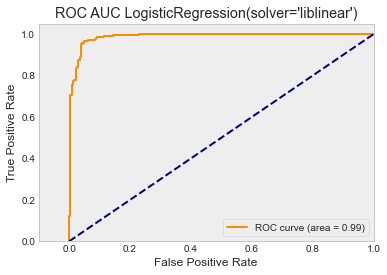

In [88]:
for_gr_l = mod2(lrc,X_train, y_train,X_test,y_test)

In [59]:
mist = k_mistakes(for_gr_l)
len(mist)

40

In [60]:
error_number =  mist[0]
vectorizer_for_example = CountVectorizer()
vectorizer_for_example.fit(X_train1)
vector = vectorizer_for_example.transform([sms.loc[error_number]["clean_text"]]).toarray()[0]
vector_pred = lrc.predict(vector.reshape(1,-1))
## Получаем неправильный ответ: 
print("Предсказанное значение: {}".format(vector_pred))
print("Фактическое значение: {}".format(sms.loc[error_number]["label_num"]))

Предсказанное значение: [1]
Фактическое значение: 0


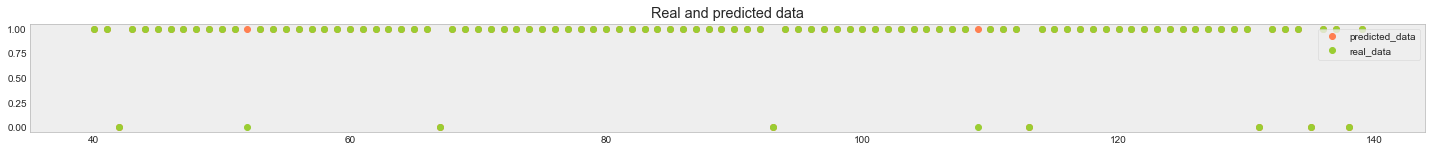

In [61]:
import matplotlib.pyplot as plt 
pred_values = lrc.predict(X_test)

n = 100

xval = [x for x in range(40,len(y_test))][:n]
plt.figure(figsize=(25, 2))
plt.title("Real and predicted data")
#plt.plot(xval, list(y_test)[:n], "ro", c = "yellowgreen", label = "real_data")
plt.plot(xval, list(pred_values)[:n], "ro", c = "coral", label = "predicted_data")
plt.plot(xval, list(y_test)[:n], "ro", c = "yellowgreen", label = "real_data")
plt.legend()
plt.grid()

In [62]:
def visualize_coefficients(classifier, feature_names, n_top_features=20):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['coral' if c < 0 else 'yellowgreen' for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

### Слова в сообщениях, наиболее часто встречающиеся в spam и ham

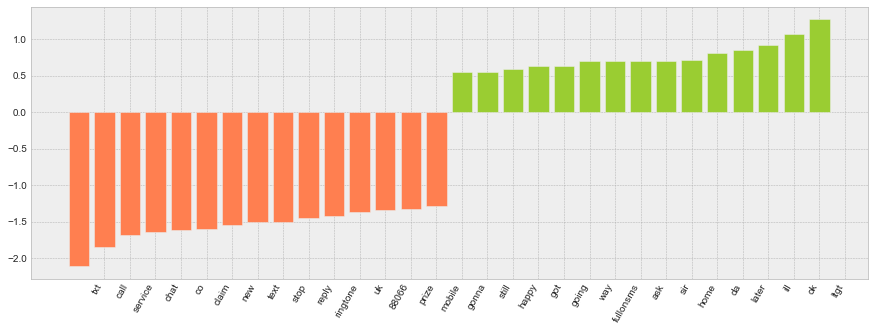

In [63]:
visualize_coefficients(lrc, cv.get_feature_names(),n_top_features=15)

In [64]:
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(),
                                # for some reason n_jobs > 1 won't work 
                                # with GridSearchCV's n_jobs > 1
                                LogisticRegression(solver='liblinear'))#, n_jobs=1))

text_pipe_logit.fit(X_train1, y_train)
print(text_pipe_logit.score(X_test1, y_test))

0.9760765550239234


#### GridSearch

In [65]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-10, 0, 10)}
grid_logit = GridSearchCV(text_pipe_logit, 
                          param_grid_logit, 
                          return_train_score=True, 
                          cv=4, n_jobs=-1)

grid_logit.fit(X_train1, y_train)

Wall time: 13.5 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.00000000e-10, 1.29154967e-09, 1.66810054e-08, 2.15443469e-07,
       2.78255940e-06, 3.59381366e-05, 4.64158883e-04, 5.99484250e-03,
       7.74263683e-02, 1.00000000e+00])},
             return_train_score=True)

In [66]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 1.0}, 0.9774358974358974)

Модель с подобранными параметрами выдает результат лучше, чем без подбора, но незначительно.

In [67]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();

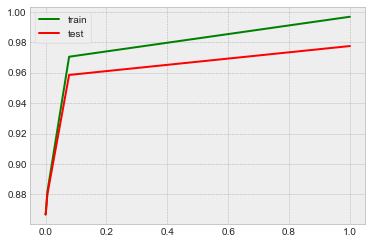

In [68]:
plot_grid_scores(grid_logit, 'logisticregression__C')

In [69]:
grid_logit.score(X_test1, y_test)

0.9760765550239234

## MultinomialNB
## Метод Байеса

Accuracy 0.9808612440191388
ROC AUC 0.9826717937503037
F1-score 0.9889426399447133

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       228
           1       0.99      0.99      0.99      1444

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672

[[ 209   19]
 [  13 1431]]


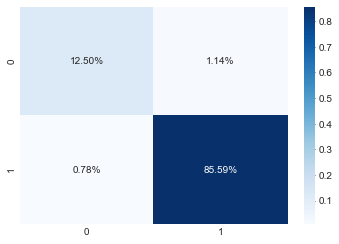

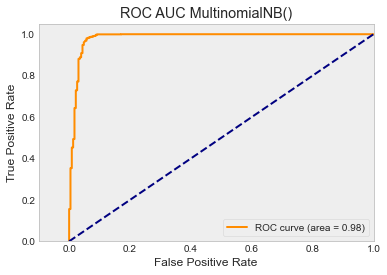

In [89]:
for_gr_b = mod2(mnb,X_train, y_train,X_test,y_test)

In [90]:
mist = k_mistakes(for_gr_b)
len(mist)

32

При решении задачи классификации существует вероятность переобучения моделей. 
Для того чтобы это предотвратить можно провести обучение на меньшем объеме данных. 

## Обучение на меньшем объеме данных

#### Функция для последовательного уменьшения данных 

In [153]:
def mod3(DF, volume_list, models):
    f1_score_list = []
    auc_list = []
    t = []
    best_model = 0
    best_score = 0
    best_roc_auc_score = 0

    list_of_f1_without_param = []    
    list_of_roc_auc_without_param = []
    
    for volume in volume_list:
        DF.head(volume)
        y = DF.label_num.values
        X = DF.clean_text.values
        X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        cv = CountVectorizer()
        cv.fit(X_train1)
        X_train = cv.transform(X_train1)
        X_test = cv.transform(X_test1)
    
        for name_model in models:
            start_time = timer()
            model = name_model.fit(X_train, y_train)
            end_time = timer()
            
            y_pred_class = name_model.predict(X_test)
            y_pred_prob = name_model.predict_proba(X_test)[:, 1]
            # calculate AUC
            roc_auc_score1 = metrics.roc_auc_score(y_test, y_pred_prob)
            auc_list.append(roc_auc_score1)
            print('')
                           
            f1 = classification_report(y_test, model.predict(X_test), output_dict = True)['weighted avg']['f1-score']
            f1_score_list.append(f1)
            auc_list.append(roc_auc_score1)
        
            list_of_f1_without_param.append(f1)
            list_of_roc_auc_without_param.append(roc_auc_score1)
            
            report = classification_report(y_test, model.predict(X_test))
            print(f'                   Модель: {type(name_model).__name__} ')
            print(f' Объем выборки: {volume}')
            print(f' AUC ROC :{roc_auc_score1}')
            print(f' F1-Score: {f1}')
            print(' ')
            print(f' Report {report}')
            print(' ')
            tim = end_time - start_time
            print(f'Время обучения модели:{tim}')
            t.append(tim)
            
    plt.plot(list(range(len(volume_list))), list_of_f1_without_param)
    plt.xticks(list(range(len(volume_list))), volume_list)
    plt.xlabel('Объем выборки')
    plt.ylabel('F1-SCORE')
    plt.suptitle('График зависимости F1-SCORE от выборки ')
    plt.show()

    plt.plot(list(range(len(volume_list))), list_of_roc_auc_without_param)
    plt.xticks(list(range(len(volume_list))), volume_list)
    plt.xlabel('Объем выборки')
    plt.ylabel('AUC ROC')
    plt.suptitle('График зависимости AUC ROC от выборки ')
    plt.show() 
    
#     plt.plot(list(range(len(volume_list))), list_of_roc_auc_without_param)
#     plt.xticks(list(range(len(volume_list))), t)
#     plt.xlabel('Время обучения')
#     plt.ylabel('AUC ROC')
#     plt.suptitle('График зависимости AUC ROC от времени ')
#     #plt.suptitle('График зависимости времени от выборки ')
#     plt.show() 


                   Модель: LogisticRegression 
 Объем выборки: 100
 AUC ROC :0.9901180490835664
 F1-Score: 0.9777502360530647
 
 Report               precision    recall  f1-score   support

           0       0.99      0.85      0.91       222
           1       0.98      1.00      0.99      1450

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672

 
Время обучения модели:0.07156319999921834

                   Модель: LogisticRegression 
 Объем выборки: 500
 AUC ROC :0.9881517610497237
 F1-Score: 0.9721063995038923
 
 Report               precision    recall  f1-score   support

           0       0.97      0.82      0.89       224
           1       0.97      1.00      0.98      1448

    accuracy                           0.97      1672
   macro avg       0.97      0.91      0.94      1672
weighted avg       0.97      0.97      0.97      1672

 
Время обучения модели:0.04

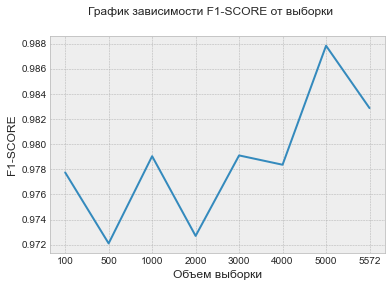

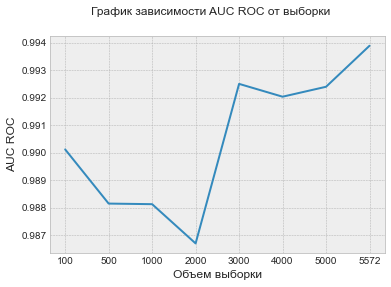

In [154]:
mod3(sms, [100,500,1000,2000,3000,4000,5000,5572],[LogisticRegression(solver='liblinear')])

In [107]:
def mod4(sms, n_list, model):
    for n in n_list:
        rocl = []
        ff = []
        sms2 = pd.DataFrame(columns=['clean_text', 'label_num'])
        k=0
        for i in range(sms.shape[0]):
            if sms['label_num'][i] == 1:
                if k<int((sms.shape[0]-747)*n):
                    sms2.loc[i] = sms.loc[i]
                    k+=1
            else: sms2.loc[i] = sms.loc[i]
        print('Объем набора данных',sms2.shape)
        sms2['label_num'] = sms2.label_num.map({1:1, 0:0})
        
        labels = ['spam', 'ham']
        x = [sms2[sms2['label_num'] == 0].shape[0], sms2[sms2['label_num'] == 1].shape[0]] # количество сообщений определенного label

        fig1, ax1 = plt.subplots(figsize=(5, 5))
        ax1.pie(x, labels=labels, explode = (0.3, 0),autopct='%1.1f%%', colors = ['coral','yellowgreen'], 
            radius = 1.5, counterclock = False)
        plt.title('Целевая переменная Label')
        ax1.axis('equal')
        ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))
        plt.show()
        
        X2 = sms2['clean_text']
        y2 = sms2['label_num']

        X_train12, X_test12, y_train2, y_test2 = train_test_split(X2, y2,  test_size = 0.3)
        cv = CountVectorizer()
        cv.fit(X_train12)
        X_train2 = cv.transform(X_train12)
        X_test2 = cv.transform(X_test12)
        lrc = model
        for_gr_l2 = mod2(lrc,X_train2, y_train2,X_test2,y_test2)
        
        

Объем набора данных (4124, 2)


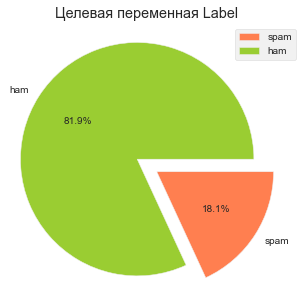

Accuracy 0.970113085621971
ROC AUC 0.9802033910772738
F1-score 0.9822712026832775

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       212
           1       0.97      1.00      0.98      1026

    accuracy                           0.97      1238
   macro avg       0.98      0.91      0.94      1238
weighted avg       0.97      0.97      0.97      1238

[[ 176   36]
 [   1 1025]]
Объем набора данных (3159, 2)


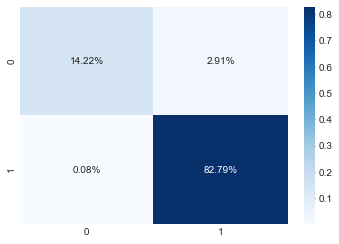

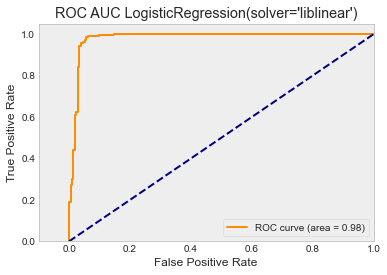

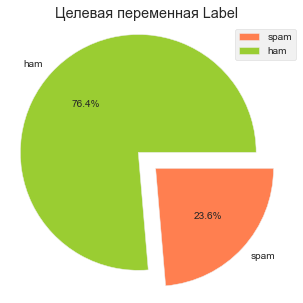

Accuracy 0.9662447257383966
ROC AUC 0.9829076066972274
F1-score 0.9781718963165076

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       226
           1       0.96      0.99      0.98       722

    accuracy                           0.97       948
   macro avg       0.97      0.94      0.95       948
weighted avg       0.97      0.97      0.97       948

[[199  27]
 [  5 717]]
Объем набора данных (2677, 2)


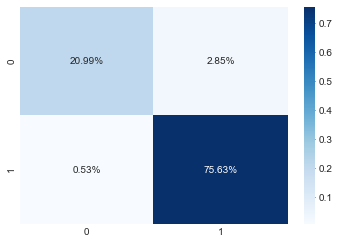

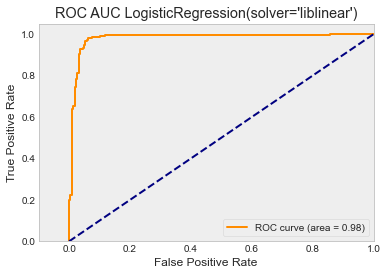

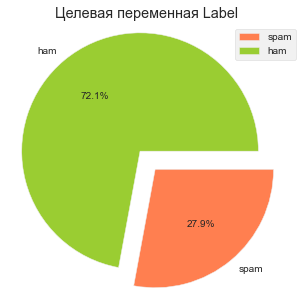

Accuracy 0.9664179104477612
ROC AUC 0.9892970762005757
F1-score 0.9769033361847733

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       230
           1       0.96      0.99      0.98       574

    accuracy                           0.97       804
   macro avg       0.97      0.95      0.96       804
weighted avg       0.97      0.97      0.97       804

[[206  24]
 [  3 571]]
Объем набора данных (2194, 2)


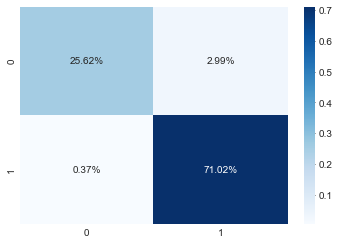

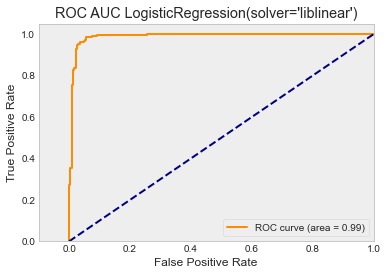

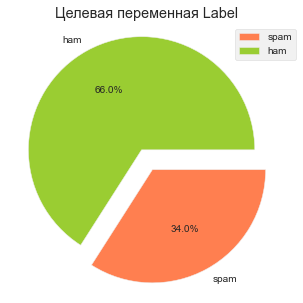

Accuracy 0.9575113808801214
ROC AUC 0.9826050942224063
F1-score 0.96875

              precision    recall  f1-score   support

           0       0.98      0.90      0.93       220
           1       0.95      0.99      0.97       439

    accuracy                           0.96       659
   macro avg       0.96      0.94      0.95       659
weighted avg       0.96      0.96      0.96       659

[[197  23]
 [  5 434]]
Объем набора данных (1712, 2)


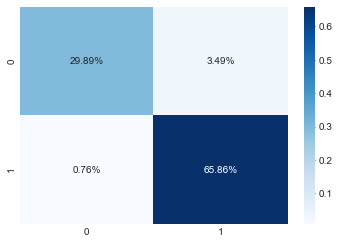

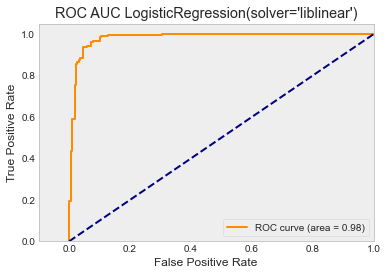

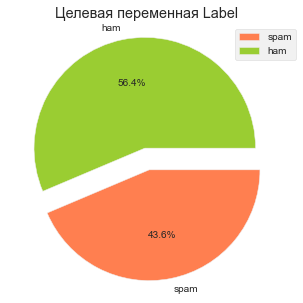

Accuracy 0.9319066147859922
ROC AUC 0.9835614559200098
F1-score 0.940374787052811

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       236
           1       0.89      0.99      0.94       278

    accuracy                           0.93       514
   macro avg       0.94      0.93      0.93       514
weighted avg       0.94      0.93      0.93       514

[[203  33]
 [  2 276]]
Объем набора данных (1229, 2)


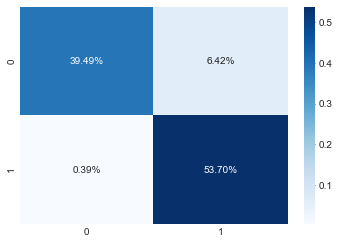

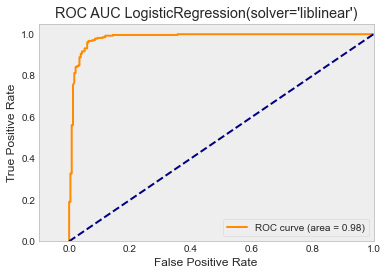

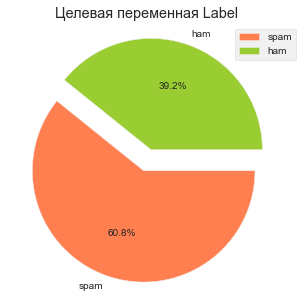

Accuracy 0.9349593495934959
ROC AUC 0.9850769136483423
F1-score 0.92

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       222
           1       0.90      0.94      0.92       147

    accuracy                           0.93       369
   macro avg       0.93      0.94      0.93       369
weighted avg       0.94      0.93      0.94       369

[[207  15]
 [  9 138]]
Объем набора данных (988, 2)


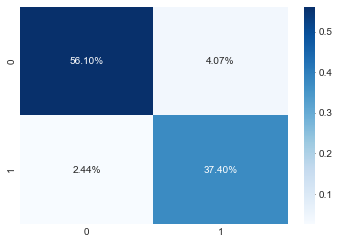

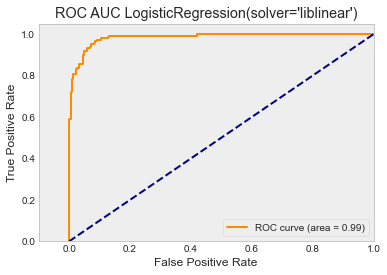

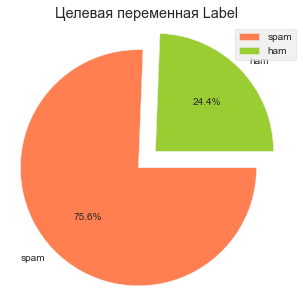

Accuracy 0.9326599326599326
ROC AUC 0.9796834101956875
F1-score 0.8666666666666667

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       226
           1       0.82      0.92      0.87        71

    accuracy                           0.93       297
   macro avg       0.90      0.93      0.91       297
weighted avg       0.94      0.93      0.93       297

[[212  14]
 [  6  65]]


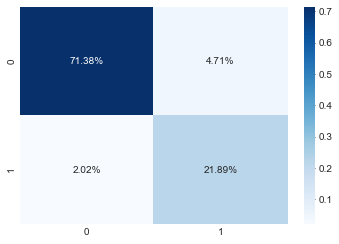

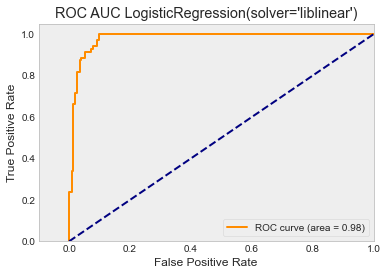

In [108]:
mod4(sms, [0.70,0.50,0.40,0.30,0.20,0.10,0.05], LogisticRegression(solver='liblinear'))

C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy 0.9455782312925171
ROC AUC 0.9893116540112248

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       208
           1       0.92      0.99      0.95       233

    accuracy                           0.95       441
   macro avg       0.95      0.94      0.95       441
weighted avg       0.95      0.95      0.95       441

[[187  21]
 [  3 230]]


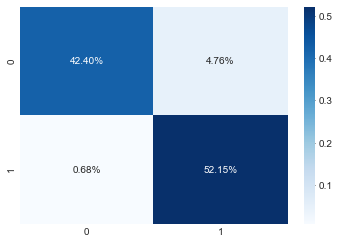

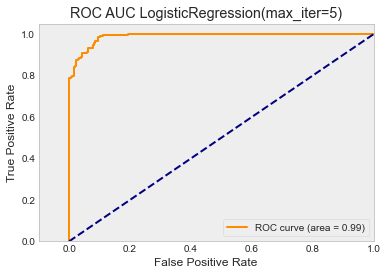

In [179]:
for_gr_b2 = mod2(LogisticRegression(max_iter=5), X_train2, y_train2, X_test2, y_test2)

И при значительном уменьшении объема данных модель работает хорошо и имеет высокие показатели оценок

Accuracy 0.9365079365079365
ROC AUC 0.9917877187190491

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       208
           1       0.98      0.90      0.94       233

    accuracy                           0.94       441
   macro avg       0.94      0.94      0.94       441
weighted avg       0.94      0.94      0.94       441

[[203   5]
 [ 23 210]]


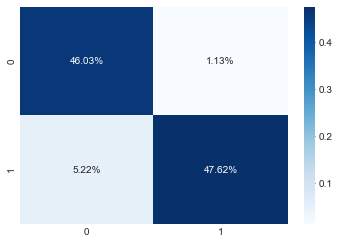

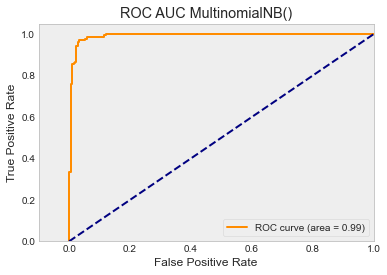

In [161]:
for_gr_b2 = mod2(mnb, X_train2, y_train2, X_test2, y_test2)

### Таким образом, модели LogisticRegression также имеют высокие показатели и при уменьшении объема данных. Следовательно, модель качественная и может быть применима для фильтрации спама